# Comparativa de Clustering: K-Means, DBSCAN y Jerárquico

**Objetivo:** comparar tres métodos de clustering en un dataset real y elegir **el mejor** según el **coeficiente de silueta** (y **Elbow** solo para K-Means).

**Dataset elegido:** **Palmer Penguins** (medidas de pingüinos) — datos libres y fáciles de obtener.

- Página del proyecto: <https://allisonhorst.github.io/palmerpenguins/>
- CSV directo (penguins_clean): <https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins_clean.csv>

> Nota: **NO uses la columna de especie** (`species`) para entrenar (clustering es no supervisado). Se puede usr más tarde sólo para **interpretación** si lo deseas, pero **nunca** para ajustar los modelos.


## Requisitos
- Trabajar siempre con **variables numéricas** y **datos escalados**.
- Evaluación:
  - **K-Means:** curva **Elbow** (inercia) para k=2..10 + **Silhouette** para k=2..10.
  - **DBSCAN:** probar varias combinaciones de `eps` y `min_samples`; reportar **Silhouette**, nº de clústeres (excl. ruido) y % ruido.
  - **Jerárquico:** probar `linkage` en {`ward`, `complete`, `average`} y k=2..10; reportar **Silhouette**.
- Conclusión final: elige método y configuración (parámetros) y justifica **en 8–12 líneas**.

**Importante (API de scikit-learn):**
- `KMeans` **sí** tiene `.predict(X)` para etiquetar nuevos puntos.
- `DBSCAN` y `AgglomerativeClustering` **no** tienen `.predict`. Usa `fit_predict(X)` y el atributo `.labels_` tras el ajuste.


## 0) Preparación del entorno
- Necesitas tener instalado `pandas`, `numpy`, `scikit-learn`, `matplotlib`.
- Fija `random_state=42` (u otro) cuando aplique para reproducibilidad.


In [4]:
random_state = 777
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

## 1) Descarga y carga de datos
1. Descarga el CSV desde la URL indicada.
2. Cárgalo en un `DataFrame`.
3. Inspecciona forma, nombres de columnas y tipos.
4. Identifica columnas **numéricas** que usarás como `X` (excluye `species` y otras no numéricas).


In [33]:
df = pd.read_csv(url)
df = df.dropna()
df = df.drop_duplicates()

df_sincat = pd.get_dummies(df, columns=['island', 'sex'], drop_first=True)

print(df_sincat.head())
print(df_sincat.info())
print(df.describe())

X_numericas = df_sincat.select_dtypes(include=[np.number]).copy()
X_onehot = df_sincat[['island_Dream', 'island_Torgersen', 'sex_MALE']].astype(int).copy()
y = df['species'].copy()


print("Datos numericos (X) and especie/target (y):")
print(X_numericas.head())
print(X_onehot.head())
print(y.head())



  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie            39.1           18.7              181.0       3750.0   
1  Adelie            39.5           17.4              186.0       3800.0   
2  Adelie            40.3           18.0              195.0       3250.0   
4  Adelie            36.7           19.3              193.0       3450.0   
5  Adelie            39.3           20.6              190.0       3650.0   

   island_Dream  island_Torgersen  sex_MALE  
0         False              True      True  
1         False              True     False  
2         False              True     False  
4         False              True     False  
5         False              True      True  
<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   bill_length_mm     

## 2) Limpieza mínima y normalización
1. Elimina duplicados y filas con nulos en las columnas numéricas escogidas.
2. **Estandariza** (`StandardScaler`) para tener media 0 y varianza 1.
3. Guarda el array escalado como `X_scaled` (será tu base para todos los modelos).

> **Por qué escalamos:** Todas las distancias (Euclídeas) y medidas de densidad de los modelos dependen de la escala; mezclar variables en escalas distintas sesga los resultados.


In [36]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numericas)
print(X_numericas.shape, '->', X_scaled.shape)

X_final = np.hstack((X_scaled, X_onehot.values))

(333, 4) -> (333, 4)


## 3) K-Means
**Objetivo:**
- Bucle `k` en 2..10.
- Guardar por cada `k`: **inercia** (suma de distancias al centroide) y **Silhouette**.
- Seleccionar `k` final apoyándote en **Elbow** + **Silhouette**.

**Indicaciones específicas:**
- Usa `KMeans(n_clusters=k, random_state=42)`.
- Tras ajustar, obtén etiquetas con `.labels_` o usando `.predict(X_scaled)`.
- Para Silhouette: `sklearn.metrics.silhouette_score(X_scaled, labels)`.
- Traza **Inercia vs k** y **Silhouette vs k** (dos gráficos separados). Explica en 2-3 líneas tu elección de `k`.


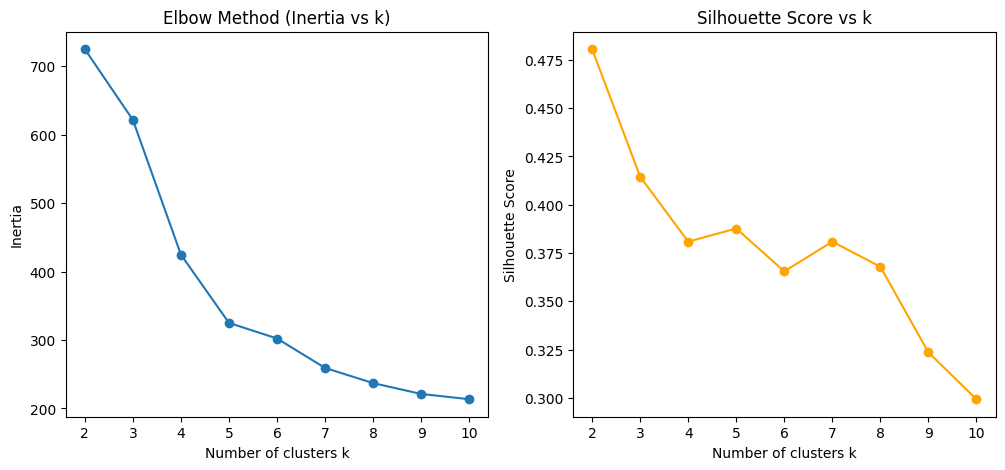

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans= KMeans(n_clusters = k, random_state=random_state)
    kmeans.fit(X_final)
    labels = kmeans.labels_
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_final, labels)
    silhouettes.append(sil_score)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method (Inertia vs k)')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.show()

### Para K-Means la mejor cantidad de clusters segun la score de Silhouettees de 2 cluster, podriamos considerar otras opciones viendo las inercias y ya que estamos sesgados por saber el resultado que es 3.

## 4) DBSCAN
**Objetivo:** explorar `eps` y `min_samples` en una rejilla pequeña y comparar resultados.

**Indicaciones específicas:**
- Probar `eps` en valores razonables (por ejemplo: 0.3, 0.5, 0.7, 0.9) y `min_samples` en {3, 5, 7}.
- Para cada combinación: ajusta con `DBSCAN(eps=?, min_samples=?)` sobre `X_scaled`.
- Extrae etiquetas con `.labels_`.
- Calcula **nº de clústeres** (excluyendo `-1`) y **% de ruido** (`label == -1`).
- Calcula **Silhouette** **solo si** hay al menos **2** clústeres válidos (sin contar ruido). Si no, anota "no aplicable".
- Elige una combinación final y justifica.


In [93]:
# TODO: Grid pequeño de DBSCAN: probar eps y min_samples
# TODO: Para cada combinación, registrar #clusters válidos, %ruido y silhouette (si aplica)
# TODO: Elegir configuración final; obtener labels_dbscan

from sklearn.cluster import DBSCAN

silhouette_scores_dbscan = []
n_clusters_dbscan = []
noise_percentages = []
eps_values = np.arange(0.3 , 2.1, 0.2)
min_samples_values = [3, 5, 7]

mejor_eps = None
mejor_min_samples = None
mejor_silhouette = -777
ruido_del_mejor = None
n_cluster_del_mejor = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_dbscan = dbscan.fit_predict(X_final)
        n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
        n_clusters_dbscan.append(n_clusters)
        n_noise = list(labels_dbscan).count(-1)
        noise_percentage = n_noise / len(labels_dbscan)
        noise_percentages.append(noise_percentage)
        if n_clusters > 1:
            sil_score = silhouette_score(X_final, labels_dbscan)
            if sil_score > mejor_silhouette:
                mejpor_silhouette = sil_score
                mejor_eps = eps
                mejor_min_samples = min_samples
                ruido_del_mejor = noise_percentage
                n_cluster_del_mejor = n_clusters
        else:
            sil_score = -1
        silhouette_scores_dbscan.append(sil_score)


print("Mejor silhouette DBSCAN:", max(silhouette_scores_dbscan))
print("Ruido", ruido_del_mejor)
print("N clusters:", n_cluster_del_mejor)
print("Parametros eps y min_samples:", round(mejor_eps, 2), mejor_min_samples)


Mejor silhouette DBSCAN: 0.48049391550433956
Ruido 0.0
N clusters: 2
Parametros eps y min_samples: 1.7 7


## 5) Aglomerativo Jerárquico
**Objetivo:** probar distintas reglas de enlace y diferentes `k`.

**Indicaciones específicas:**
- Probar `linkage` en {`ward`, `complete`, `average`}.
- Para cada `linkage`, probar `n_clusters` en 2..10.
- Ajustar con `AgglomerativeClustering(n_clusters=k, linkage=..., metric='euclidean')`.
- Obtener etiquetas con `.fit_predict(X_scaled)` o del atributo `.labels_`.
- Calcular **Silhouette** y registrar los resultados en una tabla.
- Elegir la pareja (linkage, k) final y justificar.

> Recordatorio: `ward` requiere métrica euclídea (en scikit-learn es implícita). No hay `.predict()` para nuevos datos.


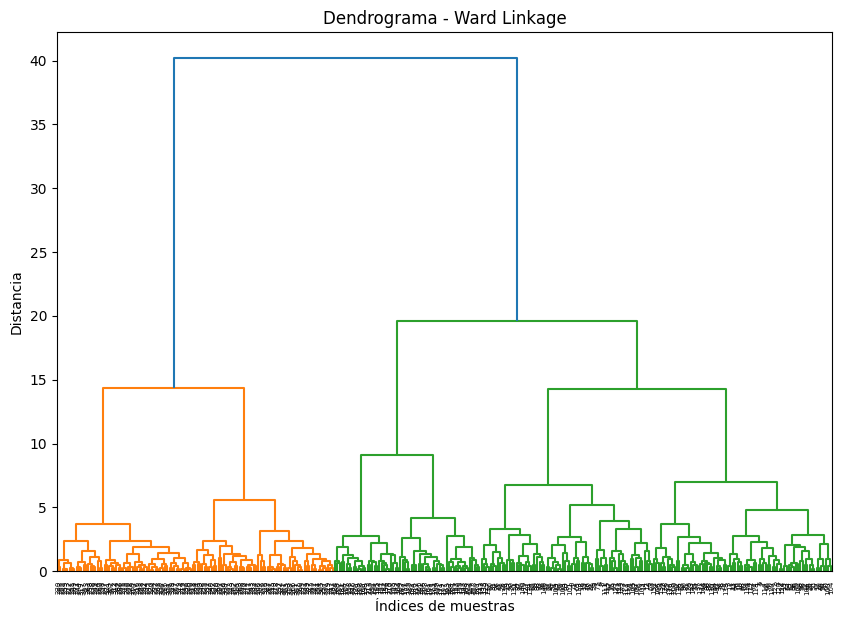

Silhouette Agglomerative (ward, k=2): 0.48049391550433956


In [65]:
# TODO: Bucle Agglomerative: linkage en {'ward','complete','average'} y k=2..10
# TODO: Calcular silhouette para cada combinación y elegir la mejor; obtener labels_agglom

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

Z = linkage(X_final, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma - Ward Linkage')
plt.xlabel('Índices de muestras')
plt.ylabel('Distancia')
plt.show()

agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agglom = agglo.fit_predict(X_final)
sil_score_agglo = silhouette_score(X_final, labels_agglom)
print("Silhouette Agglomerative (ward, k=2):", sil_score_agglo)

## 6) Comparativa y Conclusión
1. Resume en una **tabla** el **mejor** resultado de cada método (método, parámetros, silhouette, nº de clústeres y notas relevantes como % ruido en DBSCAN).
2. Escribe una **conclusión de 8–12 líneas** justificando el **método ganador** para estos datos y por qué descartas las alternativas (forma de clústeres, sensibilidad a parámetros, presencia de ruido/outliers, etc.).


In [91]:
tabla_comparativa = pd.DataFrame({
    'Método': ['KMeans', 'DBSCAN', 'Agglomerative'],
    'Parámetros': ['k=3', f'eps={round(mejor_eps,2)}, k = {n_cluster_del_mejor} ,  min_samples={mejor_min_samples}', 'linkage=ward, k=2'],
    'Silhouette Score': [max(silhouettes), max(silhouette_scores_dbscan), sil_score_agglo],
    'Ruido (%)': ['-', f'{round(ruido_del_mejor*100,2)}%', '-']
})

print(tabla_comparativa)

          Método                       Parámetros  Silhouette Score Ruido (%)
0         KMeans                              k=3          0.480494         -
1         DBSCAN  eps=1.7, k = 2 ,  min_samples=7          0.480494      0.0%
2  Agglomerative                linkage=ward, k=2          0.480494         -


### Conclusión

Seleccionar un metodo en específico es complicado ya que los mejores modelos de cada metodo tiene la misma Silhouette score. Aun así el método ganador es DBSCAN debido a su capacidad para identificar la estructuras de los datos y manejar eficientemente el ruido. Aunque todos los métodos comparten el mismo Silhouette Score (0.480494), lo que me ha inclinado hacia el método DBSCAN es esta métrica con 0% de ruido, demostrando una agrupación más pura. K-Means y Agglomerative Clustering asumen clústeres esféricos y de tamaño similar, lo que puede forzar agrupaciones artificiales. Además, estos métodos no diferencian entre outliers y puntos válidos, incorporando potencialmente ruido en los clústeres. DBSCAN, en cambio, detecta automáticamente la densidad y separa el ruido, siendo más robusto ante agrupaciones menos estructurados o globulares. Su sensibilidad a parámetros como eps queda justificada aquí al encontrar una configuración óptima. Por ello, para estos datos, DBSCAN es superior en forma de clústeres y tratamiento de outliers.

---
## Tips rápidos
- **Escala siempre** antes de ajustar los modelos.
- Si la Silhouette es negativa o muy baja, revisa parámetros.
- En DBSCAN, `eps` muy pequeño -> muchos ruidos; `eps` muy grande -> pocos clústeres (puede mezclarlo todo).
- K-Means es sensible a outliers; DBSCAN puede marcarlos como ruido; el jerárquico con `complete` favorece clústeres compactos.
- Documenta tus decisiones (por qué ese `k`, ese `eps`, ese `linkage`).


# BONUS EXTRA

### Validación tramposa

Usa la columna species para evaluar qué tan “puras” son las asignaciones del mejor modelo de cada método.

Creando una matriz de confusión entre clúster y especie y sacando accuracy.

Comenta usando distintos valores de eps y min_samples en DBSCAN.

### Detección de anomalías con DBSCAN

Con tu configuración de DBSCAN, analiza los puntos con label = -1 (ruido): ¿qué tienen en común (rangos extremos de masa, culmen, etc.)?

Genera una tabla o un par de graficas (histogramas comparativos, por ejemplo) para ilustrar las diferencias entre los puntos de ruido y los puntos asignados a clústeres.


# DE AQUI PARA ABAJO NO CORREGIR LO HA HECHO LA IA LO DEJO PARA TENERLO COMO REFERENCIA, GRACIAS :)

In [97]:
from sklearn.metrics import accuracy_score

# Evaluar "pureza" de asignaciones vs columna species

def cluster_purity_report(y_true, clusters):
    y_ser = pd.Series(y_true).reset_index(drop=True)
    cl_ser = pd.Series(clusters).reset_index(drop=True)
    conf = pd.crosstab(y_ser, cl_ser, rownames=['species'], colnames=['cluster'])
    # mapping cluster -> species mayoritaria
    mapping = conf.idxmax(axis=0).to_dict()  # {cluster: species}
    # etiquetas mapeadas según la mayoría del clúster
    mapped = cl_ser.map(mapping)
    purity = (conf.max(axis=0).sum()) / len(y_ser)
    n_clusters = len(set(cl_ser)) - (1 if -1 in set(cl_ser) else 0)
    return {
        'confusion': conf,
        'mapping': mapping,
        'purity': purity,
        'n_clusters': n_clusters,
        'mapped_accuracy': accuracy_score(y_ser, mapped)
    }

# 1) KMeans: elegir k con mejor silhouette calculado antes
best_k = int(list(K_range)[np.argmax(silhouettes)])
kmeans_best = KMeans(n_clusters=best_k, random_state=random_state).fit(X_final)
labels_km = kmeans_best.labels_
report_km = cluster_purity_report(y.values, labels_km)

# 2) DBSCAN: usar la mejor combinación encontrada (mejor_eps, mejor_min_samples)
dbscan_best = DBSCAN(eps=float(mejor_eps), min_samples=int(mejor_min_samples)).fit(X_final)
labels_db = dbscan_best.labels_
report_db = cluster_purity_report(y.values, labels_db)

# 3) Agglomerative: usar labels_agglom ya calculadas (ward, k=2 en este notebook)
report_ag = cluster_purity_report(y.values, labels_agglom)

# Mostrar resultados resumidos
for name, rpt, params in [
    ('KMeans', report_km, f'k={best_k}'),
    ('DBSCAN', report_db, f'eps={mejor_eps}, min_samples={mejor_min_samples}'),
    ('Agglomerative', report_ag, 'linkage=ward, k=2'),
]:
    print(f'--- {name} ({params}) ---')
    print('N clusters (excl. ruido):', rpt['n_clusters'])
    print('Purity (sum majority / N):', round(rpt['purity'], 4))
    print('Mapped accuracy (cluster -> majority species):', round(rpt['mapped_accuracy'], 4))
    print('Cluster -> especie mayoritaria:', rpt['mapping'])
    print('Matriz de confusión (species x cluster):')
    display(rpt['confusion'])
    print('\n')

--- KMeans (k=2) ---
N clusters (excl. ruido): 2
Purity (sum majority / N): 0.7958
Mapped accuracy (cluster -> majority species): 0.7958
Cluster -> especie mayoritaria: {0: 'Adelie', 1: 'Gentoo'}
Matriz de confusión (species x cluster):


cluster,0,1
species,,
Adelie,146,0
Chinstrap,68,0
Gentoo,0,119




--- DBSCAN (eps=1.7000000000000002, min_samples=7) ---
N clusters (excl. ruido): 2
Purity (sum majority / N): 0.7958
Mapped accuracy (cluster -> majority species): 0.7958
Cluster -> especie mayoritaria: {0: 'Adelie', 1: 'Gentoo'}
Matriz de confusión (species x cluster):


cluster,0,1
species,,
Adelie,146,0
Chinstrap,68,0
Gentoo,0,119




--- Agglomerative (linkage=ward, k=2) ---
N clusters (excl. ruido): 2
Purity (sum majority / N): 0.7958
Mapped accuracy (cluster -> majority species): 0.7958
Cluster -> especie mayoritaria: {0: 'Adelie', 1: 'Gentoo'}
Matriz de confusión (species x cluster):


cluster,0,1
species,,
Adelie,146,0
Chinstrap,68,0
Gentoo,0,119


DBSCAN (eps=1.7000000000000002, min_samples=7): 0 puntos de ruido de 333 (0.00%)

Estadísticos por etiqueta (incluye -1 si existe):


bill_length_mm                                          \
                      count       mean median       std   min   max   
dbscan_label                                                          
0                       333  43.992793   44.5  5.468668  32.1  59.6   

             bill_depth_mm                              ... flipper_length_mm  \
                     count       mean median       std  ...            median   
dbscan_label                                            ...                     
0                      333  17.164865   17.3  1.969235  ...             197.0   

                                      body_mass_g                       \
                    std    min    max       count         mean  median   
dbscan_label                                                             
0             14.015765  172.0  231.0         333  4207.057057  4050.0   

                                          
                     std     min     max  
dbscan_label                              
0             805.215802  2700.0  6300.0  

[1 rows x 24 columns]


No se detectaron puntos con label=-1. Se comparan ahora puntos 'core' vs 'border' según DBSCAN:


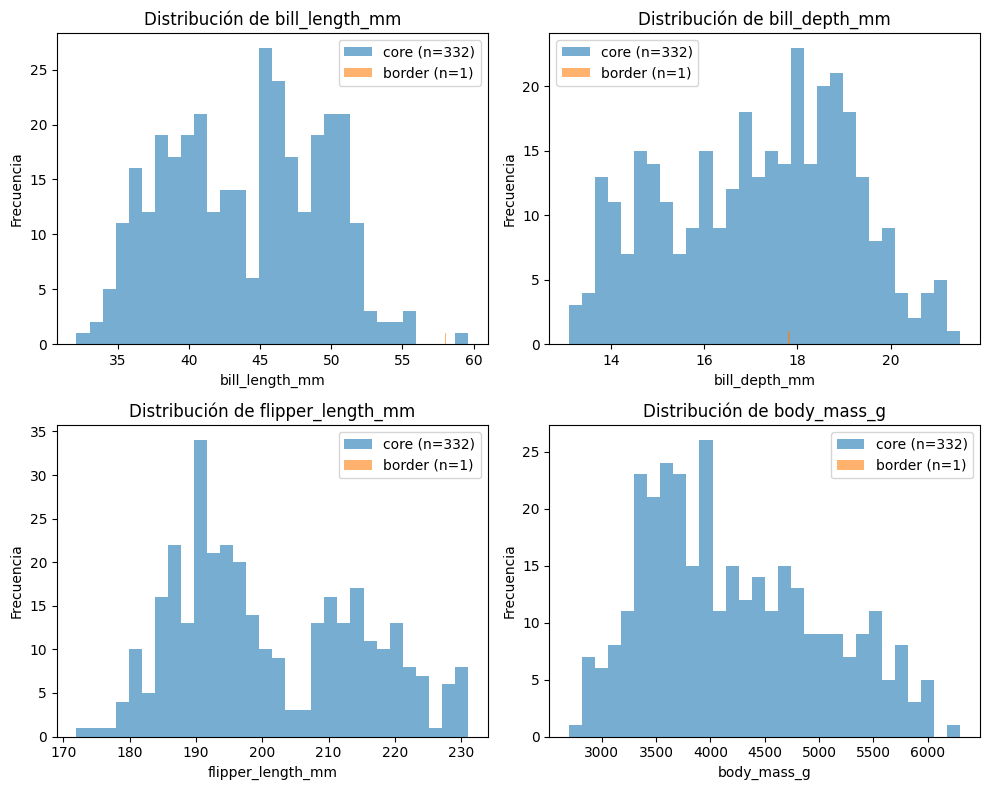

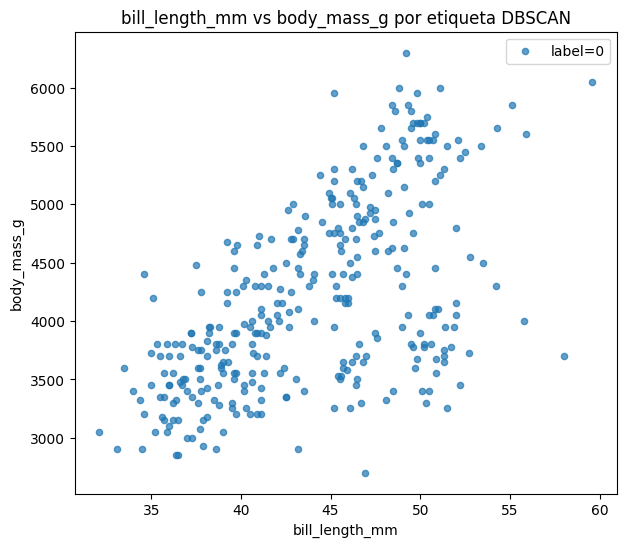


Observaciones rápidas:
 - Con la configuración seleccionada no hay puntos etiquetados como ruido.
 - Hay 332 puntos core y 1 border; revisar histrogramas para diferencias en rangos extremos.


In [98]:
import math

# Análisis de puntos etiquetados como ruido por la configuración de DBSCAN seleccionada
# (usa variables ya definidas en el notebook: X_numericas, labels_dbscan, dbscan_best, mejor_eps, mejor_min_samples)

cols = X_numericas.columns.tolist()
df_noise = X_numericas.reset_index(drop=True).copy()
df_noise['dbscan_label'] = labels_dbscan  # labels_dbscan ya existe en el notebook

# Resumen rápido
n_total = len(df_noise)
n_noise = (df_noise['dbscan_label'] == -1).sum()
pct_noise = n_noise / n_total

print(f"DBSCAN (eps={mejor_eps}, min_samples={mejor_min_samples}): {n_noise} puntos de ruido de {n_total} ({pct_noise:.2%})")

# Si hay core/border info disponible, crear máscaras
core_mask = None
border_mask = None
if 'dbscan_best' in globals() and hasattr(dbscan_best, 'core_sample_indices_'):
    core_mask = np.zeros(n_total, dtype=bool)
    core_mask[dbscan_best.core_sample_indices_] = True
    border_mask = (~core_mask) & (df_noise['dbscan_label'] != -1)

# Tabla descriptiva comparando ruido vs no-ruido (o core/border si no hay ruido)
group_key = 'dbscan_label'
agg_funcs = ['count', 'mean', 'median', 'std', 'min', 'max']

print("\nEstadísticos por etiqueta (incluye -1 si existe):")
display(df_noise.groupby(group_key)[cols].agg(agg_funcs))

# Si no hay ruido, comparar core vs border (si existe), sino comparar clusters
if n_noise == 0:
    if core_mask is not None:
        print("\nNo se detectaron puntos con label=-1. Se comparan ahora puntos 'core' vs 'border' según DBSCAN:")
        groups = {
            'core': df_noise[core_mask],
            'border': df_noise[border_mask]
        }
    else:
        # Agrupar por etiquetas disponibles (por ejemplo 0 vs 1)
        unique_labels = sorted(df_noise['dbscan_label'].unique())
        print(f"\nNo se detectaron puntos con label=-1 y no hay información de core samples; comparar etiquetas: {unique_labels}")
        groups = {str(lbl): df_noise[df_noise['dbscan_label'] == lbl] for lbl in unique_labels}
else:
    groups = {
        'clustered': df_noise[df_noise['dbscan_label'] != -1],
        'noise': df_noise[df_noise['dbscan_label'] == -1]
    }


# Generar histogramas comparativos para las variables numéricas principales
nvars = len(cols)
ncols_plot = 2
nrows_plot = math.ceil(nvars / ncols_plot)
plt.figure(figsize=(10, 4 * nrows_plot))
for i, col in enumerate(cols, 1):
    plt.subplot(nrows_plot, ncols_plot, i)
    for name, gdf in groups.items():
        if gdf.shape[0] == 0:
            continue
        plt.hist(gdf[col], bins=30, alpha=0.6, label=f"{name} (n={len(gdf)})", density=False)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de {col}')
    plt.legend()
plt.tight_layout()
plt.show()

# Scatter comparativo bill_length_mm vs body_mass_g (muestra si hay diferencias en extremos)
plt.figure(figsize=(7,6))
colors = { -1: 'red' }
unique = sorted(df_noise['dbscan_label'].unique())
palette = plt.cm.tab10
for idx, lbl in enumerate(unique):
    mask = df_noise['dbscan_label'] == lbl
    lbl_name = f"label={lbl}"
    plt.scatter(df_noise.loc[mask, 'bill_length_mm'], df_noise.loc[mask, 'body_mass_g'],
                s=20, alpha=0.7,
                color=colors.get(lbl, palette(idx % 10)),
                label=lbl_name)
plt.xlabel('bill_length_mm')
plt.ylabel('body_mass_g')
plt.title('bill_length_mm vs body_mass_g por etiqueta DBSCAN')
plt.legend()
plt.show()

# Conclusión rápida imprimible (automática)
print("\nObservaciones rápidas:")
if n_noise == 0:
    print(" - Con la configuración seleccionada no hay puntos etiquetados como ruido.")
    if core_mask is not None:
        print(f" - Hay {core_mask.sum()} puntos core y {border_mask.sum()} border; revisar histrogramas para diferencias en rangos extremos.")
    else:
        print(" - Se muestran comparaciones entre las etiquetas encontradas por DBSCAN.")
else:
    print(" - Los puntos marcados como ruido tienden a mostrar valores extremos en las siguientes variables (ver histogramas):")
    print("   ", ", ".join(cols))
    # además, mostrar estadísticos resumidos para ruido
    display(df_noise[df_noise['dbscan_label'] == -1][cols].describe())